In [1]:
import os
import math
from random_slope_model import RandomSlopeModel, load_model
import numpy as np
import torch
import pickle as pickle
from longitudinal_image_dataset import LongitudinalImageDataset, load_image_dataset
from longitudinal_scalar_dataset import LongitudinalScalarDataset, load_scalar_dataset
from multimodal_dataset import load_multimodal_dataset, LongitudinalDataset
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from torch import nn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import csv
from utils import plot_normal_density
%matplotlib inline  
from scipy.stats import mannwhitneyu
pval_threshold = 0.1

/Users/raphael.couronne/anaconda/envs/python3/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
# paths
project_directory = '/Users/raphael.couronne/Programming/ARAMIS/Projects/Maxime_collab/'
output_dir = os.path.join(project_directory, 'output','output_test_multimodal','output_multimodal_pet-adas_9/')

# Keys
keys = ['adas_scores', 'pet_scores']

In [3]:
residuals = {'train' : {}, 'test' : {}}
for datasubset in ['train','test']:
    for key in keys:
        key_name = key
        if key == '':
            key_name = 'all'
        residuals[datasubset][key_name] = np.loadtxt(os.path.join(output_dir, '{0}_{1}_residuals.txt'.format(datasubset,key)))

In [4]:
def load_text_output(output_dir, output_type, keys):
    res = {'train' : {}, 'test' : {}}
    
    for datasubset in ['train','test']:
        for key in keys:
            key_name = key
            if key == '':
                key_name = 'latent'
            res[datasubset][key_name] = np.loadtxt(os.path.join(output_dir, '{0}_{1}{2}.txt'.format(datasubset,key,output_type)))
    return res

In [5]:
def load_output(output_dir, keys):


    # Load .txt
    residuals = load_text_output(output_dir, '_residuals', keys)
    latent_positions = load_text_output(output_dir, 'latent_positions', [''])
    latent_trajectories = load_text_output(output_dir, 'latent_trajectories', [''])

    # Load model
    model = load_model(os.path.join(output_dir, 'model'))

    # Datasets
    datasets = {'train' : load_multimodal_dataset(os.path.join(output_dir, 'train_dataset.p')),
               'test' : load_multimodal_dataset(os.path.join(output_dir, 'test_dataset.p'))}
    
    return residuals, latent_positions, latent_trajectories, datasets, model

In [6]:
def mann_whitney_test(values, labels):
    values_pos = np.extract(labels, values)
    values_neg = np.extract(1.-labels, values)
    stat, pval = mannwhitneyu(values_pos, values_neg)
    return pval, np.mean(values_pos), np.mean(values_neg)


def get_info_for_dataset(dataset, field_name, conversion=lambda x: int(x)):         
    dico = {}

    with open('../data/covariable/ADNIMERGE.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row[field_name] != '':
                dico[float(row['RID'])] = conversion(row[field_name])

    field_dataset = []

    for rid in dataset.rids:
        field_dataset.append(dico[rid])
        """
        if field_name == 'AGE':
            if abs(float(dataset.ages_per_id[rid][0]) - dico[rid]) > 0.01:
                print('OUPS rid {} {} vs {}'\
                .format(rid, float(dataset.ages_per_id[rid][0]), dico[rid]))"""

    return np.array(field_dataset)

## Multimodal variational dataset

In [7]:
apoe_dataset = get_info_for_dataset(datasets['train'], 'APOE4', conversion=lambda x:0 if int(x)==0 else 1)
gender_dataset = get_info_for_dataset(datasets['train'], 'PTGENDER', conversion=lambda x:0 if x == 'Male' else 1)
first_visit_ages = get_info_for_dataset(datasets['train'], 'AGE', conversion= lambda x:float(x))

train_lp = latent_positions['train']['latent']

#train_lp[:, 0] = train_lp[:,0] / (model.mean_slope_norm.detach().numpy() + train_lp[:, 2]) * train_dataset.ages_std + train_dataset.ages_mean + first_visit_ages

for (name, labels) in zip(["apoe", "gender"], [apoe_dataset, gender_dataset]):
        plt.figure(figsize=(6, 6))
        #plt.xlim(-3, 3)
        #plt.ylim(-3, 3)
        print(np.min(train_lp[:, -1]), np.max(train_lp[:, -1]))
        plot_normal_density(-2, 2., -2., 2.)
        plt.scatter(train_lp[:, 0], train_lp[:, -1], c=labels)
        plt.title('Latent position vs {}'.format(name), fontsize=20)
        plt.tight_layout()
        plt.show()

        for i in range(model.encoder_dim):
            pval, mean_pos, mean_neg = mann_whitney_test(train_lp[:, i], labels)
            print(pval)
            if pval < pval_threshold:
                print('\nPVALUE for {} {} {}, {} vs {}'.format(i, name, pval, mean_pos, mean_neg))

#print("train: {} +/- {} Test: {} +/- {}".format(np.sqrt(np.mean(train_errors)), np.std(train_errors), np.sqrt(np.mean(test_errors)), np.std(test_errors)))

NameError: name 'datasets' is not defined

### Plot Trajectories

In [12]:
times[key]

[array([75.7495  , 75.751274, 75.75305 , 75.75483 , 75.75661 , 75.758385,
        75.760155, 75.76193 , 75.76371 , 75.76549 ], dtype=float32)]

adas_scores
Scalar RNN has 488 parameters
Scalar decoder has 724 parameters
Scalar RNN has 5192 parameters
Scalar decoder has 6296 parameters
{'others_log_variance': tensor([0., 0., 0., 0., 0.], requires_grad=True), 'time_shift_mean': tensor([0.], requires_grad=True), 'others_mean': tensor([0., 0., 0., 0., 0.], requires_grad=True), 'time_shift_log_variance': tensor([0.], requires_grad=True), 'alpha_mean': tensor([0.], requires_grad=True), 'alpha_log_variance': tensor([-1.2040], requires_grad=True)}
Working on 101 subjects with a total of 575 visits
Min time -2.854357361389326 Max time 2.068405229537739
Working on 101 subjects with a total of 530 visits
Min time -2.854357361389326 Max time 2.013326359446367
Multi modal dataset has 101 subjects
Working on 11 subjects with a total of 63 visits
Min time -0.9200769431165617 Max time 1.0796888983188635
Working on 11 subjects with a total of 64 visits
Min time -0.9200769431165617 Max time 1.0793982009049092
Multi modal dataset has 11 subjects

/Users/raphael.couronne/anaconda/envs/python3/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


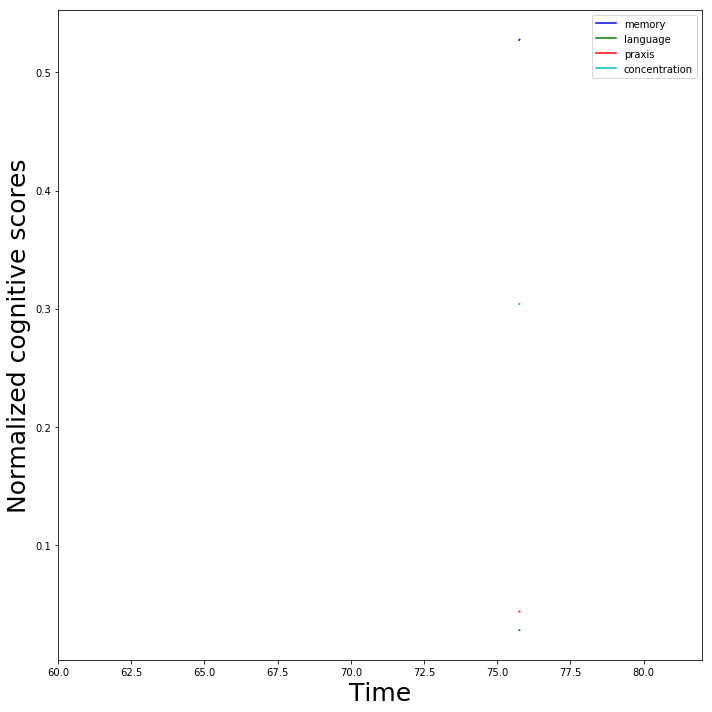

pet_scores
Scalar RNN has 488 parameters
Scalar decoder has 724 parameters
Scalar RNN has 5192 parameters
Scalar decoder has 6296 parameters
{'others_log_variance': tensor([0., 0., 0., 0., 0.], requires_grad=True), 'time_shift_mean': tensor([0.], requires_grad=True), 'others_mean': tensor([0., 0., 0., 0., 0.], requires_grad=True), 'time_shift_log_variance': tensor([0.], requires_grad=True), 'alpha_mean': tensor([0.], requires_grad=True), 'alpha_log_variance': tensor([-1.2040], requires_grad=True)}
Working on 101 subjects with a total of 575 visits
Min time -2.854357361389326 Max time 2.068405229537739
Working on 101 subjects with a total of 530 visits
Min time -2.854357361389326 Max time 2.013326359446367
Multi modal dataset has 101 subjects
Working on 11 subjects with a total of 63 visits
Min time -0.9200769431165617 Max time 1.0796888983188635
Working on 11 subjects with a total of 64 visits
Min time -0.9200769431165617 Max time 1.0793982009049092
Multi modal dataset has 11 subjects


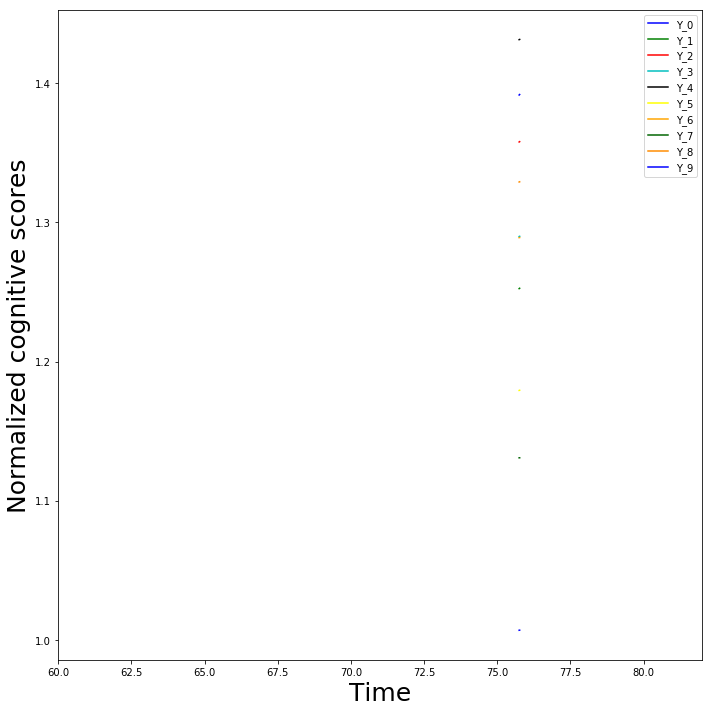

In [13]:
### For each fold, we get the model and compute the average trajectory.


# Keys
keys = ['adas_scores', 'pet_scores']

seen_times = []
parallel_trajectories = []
folds = [2]

def x_to_time(x, model, dataset):
    return (x / np.exp(model.get_alpha_mean()) + model.get_time_shift_mean()) * dataset.ages_std + dataset.ages_mean


colors_adas = ['b', 'g', 'r', 'c','black','yellow','orange','darkgreen', 'darkorange']
colors_pet = colors_adas*100

trajectories = {keys[0] : [], keys[1] : []}
times = {keys[0] : [], keys[1] : []}


for key in keys:
    print(key)
    for fold in folds:

        output_dir = os.path.join(project_directory, 'output','output_test_multimodal','output_multimodal_pet-adas_{0}/'.format(fold))
        residuals, latent_positions, latent_trajectories, datasets, model = load_output(output_dir, keys)

        print(model.prior_parameters)

        # Output dir  
        train_lt = latent_positions['train']['latent']
        train_dataset = datasets['train']



        min_x = np.min(train_lt[:, 0])
        max_x = np.max(train_lt[:, 0])


        print(min_x, max_x)
        x, trajectory = model.get_mean_trajectory(min_x, max_x)
        x = x[key]
        trajectory = trajectory[key]
        seen_times.append(x_to_time(train_lt[:,0], model, train_dataset))
        normalized_times = x_to_time(x.cpu().detach().numpy(), model, train_dataset)
        times[key].append(normalized_times)
        trajectories[key].append(trajectory.cpu().detach().numpy())

        parallel_trajs = []
        for i in range(1, model.latent_space_dim):
            orthogonal_direction = np.zeros(model.latent_space_dim)
            for val in [-1., 1.]:
                orthogonal_direction[i] = val
                x_np = np.linspace(min_x, max_x, 50)
                latent_np = np.zeros((len(x_np), model.latent_space_dim))
                latent_np[:, 0] = x_np
                latent_np = latent_np + orthogonal_direction
                latent_traj = torch.from_numpy(latent_np).type(model.type)
                scores_traj = model.decoders[key](latent_traj)
                parallel_trajs.append(scores_traj.cpu().detach().numpy())
        parallel_trajectories.append(parallel_trajs)


    if key==keys[0]:
        colors = colors_adas
    else:
        colors = colors_pet
            
        
    plt.figure(figsize=(10,10))
    for (time, seen_time, traj) in zip(times[key], seen_times, trajectories[key]):
        for i in range(min(trajectories[key][0].shape[1],10)):
            plt.plot(time, traj[:, i], label=model.data_info[key][4][i], c = colors[i])


    plt.xlim(60, 82)
    plt.xlabel('Time', fontsize=25)
    plt.ylabel('Normalized cognitive scores', fontsize=25)
    plt.tight_layout()
    plt.legend()


    if not os.path.exists(os.path.join(output_dir, 'analysis')):
        os.makedirs(os.path.join(output_dir, 'analysis'))

    plt.savefig(os.path.join(output_dir, 'analysis','{0}_average_trajectory_variational.pdf'.format(key)),
                             bbox_inches='tight', pad_inches=0)
    plt.show()  



### Further Analysis

In [ ]:
import pandas as pd
adnimerge = pd.read_csv('../data/covariable/ADNIMERGE.csv')

In [22]:
df_latent_position = pd.DataFrame(latent_positions['train']['latent'])